# CP 218 Workshop 5
## Linear Regression with Bayesian View
***
In this workshop, first we'll look at linear regression through both Frquentist (Likelihood estimate) and Bayesian prespective (Bayesian Linear Regression). Briefly, this involves learning a linear regression model from a training set of $(\mathbf{x}, y)$ pairs, where $\mathbf{x}$ is a feature vector and $y$ is a real-valued response variable.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import io
import pandas as pd

In [2]:
a= np.random.randn(1,10)
a

array([[ 0.45298711, -0.00912573,  0.88266582,  1.25521852,  0.20548559,
        -0.35642973, -0.27199956, -0.30055816,  0.39853407,  0.62269211]])

In [3]:
a[:-1]
a[1:]

array([], shape=(0, 10), dtype=float64)

In [26]:
np.arange?

### 1. Review
In this week's lecture, we saw that a linear model can be expressed as:
$$y = w_0 + \sum_{j = 1}^{m} w_j x_j = \mathbf{w} \cdot \mathbf{x} $$
where

* $y$ is the *target (or output) variable*;
* $\mathbf{x} = [x_1, \ldots, x_m]$ is a vector of *features* or *predictors* (we define $x_0 = 1$); and
* $\mathbf{w} = [w_0, \ldots, w_m]$ are the *weights*.

To fit the model, we will *minimise* the residual sum of squares (RSS) (simple case) which is also an MLE estimate for linear regression:

$$RSS(\mathbf{w}) = \sum_{i=1}^{n}(y_i - \mathbf{w} \cdot \mathbf{x}_i)^2$$

**Note:** For simplicity, we'll consider the case $m = 1$ (i.e. only one feature excluding the intercept).

***Problem Statement***

Suppose you work as a consultant to a start-up company that was looking to develop a model to estimate the manufacturing cost (cost of goods sold) in future. The startup gathered data and has asked you to develop a model to predict the year vs. the manufacturing cost.

In [4]:
csv = """1896,4.47083333333333
1900,4.46472925981123
1904,5.22208333333333
1908,4.1546786744085
1912,3.90331674958541
1920,3.5695126705653
1924,3.8245447722874
1928,3.62483706600308
1932,3.59284275388079
1936,3.53880791562981
1948,3.6701030927835
1952,3.39029110874116
1956,3.43642611683849
1960,3.2058300746534
1964,3.13275664573212
1968,3.32819844373346
1972,3.13583757949204
1976,3.07895880238575
1980,3.10581822490816
1984,3.06552909112454
1988,3.09357348817
1992,3.16111703598373
1996,3.14255243512264
2000,3.08527866650867
2004,3.1026582928467
2008,2.99877552632618
2012,3.03392977050993"""

In [5]:
# Read into a numpy array (as floats)
manufacturing_data = np.genfromtxt(io.BytesIO(csv.encode()), delimiter=",")
x = manufacturing_data[:, 0:1]
y = manufacturing_data[:, 1:2]

In [ ]:
plt.figure(figsize=(8, 4))
plt.scatter(x, y, alpha=0.2, color='red')
plt.ylabel("y (Cost)")
plt.xlabel("x (Year)")
plt.show()

### Analytical  Solution (Normal Equation)

In lecture, we saw that it's possible to solve for the optimal weights $\mathbf{w}^\star$ analytically. The solution is (MLE estimate)
$$\mathbf{w}^* = \left[\mathbf{X}^\top \mathbf{X}\right]^{-1} \mathbf{X}^\top \mathbf{y}$$
where
$$\mathbf{X} = \begin{pmatrix}
        1 & x_1 \\ 1 & x_2 \\ \vdots & \vdots \\ 1 & x_n
    \end{pmatrix}
  \quad \text{and} \quad
  \mathbf{y} = \begin{pmatrix}
          y_1 \\ y_2 \\ \vdots \\ y_n
      \end{pmatrix}
$$

We construct $\mathbf{X}$ in the code block below, remembering to include the $x_0 = 1$ column for the bias (intercept).

In [ ]:
X = np.hstack((np.ones_like(x), x))
print(X)

To get the solution using Normal eequation, we solve the following system of linear equations:
$$\mathbf{X}^\top\mathbf{X} \mathbf{w}^\star = \mathbf{X}^\top\mathbf{y}$$

This can be done in numpy using the command `np.linalg.solve`. Dot product can be done using `np.dot`. (Try `np.linalg.solve?` or `np.dot?` in a cell to see what inputs they take")

In [ ]:
w = np.linalg.solve(np.dot(X.T, X), np.dot(X.T, y))
print(w)

Let's examine the quality of fit for these values for the weights $w_0$ and $w_1$. We create a vector of "test" values `x_test` and a function to compute the predictions according to the model.

In [9]:
x_test = np.arange(1890, 2032)[:, None]

def predict(x_test, w0, w1):
    return w0 + w1 * x_test

In [10]:
w0, w1 = w

Now plot the test predictions with a blue line on the same plot as the data.

In [ ]:
def plot_fit(x_test, y_test, x, y):
    plt.plot(x_test, y_test, 'b-')
    plt.plot(x, y, 'rx')
    plt.ylabel("y (Cost)")
    plt.xlabel("x (Year)")
    plt.show()


plot_fit(x_test, predict(x_test, w0, w1), x, y)

We'll compute the residual sum of squares $RSS(w_0,w_1)$ on the training set to measure the goodness of fit.

Expanding out the RSS for this simple case (where $\mathbf{w}=[w_0, w_1]$) we have:
$$RSS(w_0, w_1) = \sum_{i=1}^{n}(y_i - w_0 - w_1 x_i)^2$$

In [ ]:
def compute_RSS(x, y, w0, w1):
    return ((y - w0 - w1*x)**2).sum()

print(compute_RSS(x, y, w0, w1))

The error we computed above is the *training* error. It doesn't assess the model's generalization ability, it only assesses how well it's performing on the given training data.

### Model Complexity and Regularization


Now we will review overfitting, model selection and regularisation. Note that the lessons here apply equally to classification, however it's more convenient to visualise regression models.

Now we will consider a more complex polynomial function. Where before we had instances of the form,
$$\phi(\mathbf{x}) = [ 1~ x ]$$
now we will be using e.g.,
$$\phi(\mathbf{x}) = [ 1 ~x~ x^2~ x^3~ x^4]$$
for a quartic model. We will consider a range of polynomial models of different orders.

To implement this we will use *basis functions* which provide a neat way of representing our data instances such that we can still use all the linear models to achieve learn a non-linear model.

#### Data Preparation

In [ ]:
num_data = x.shape[0]
num_pred_data = 100 # how many points to use for plotting predictions
x_pred = np.linspace(1890, 2016, num_pred_data)[:, None] # input locations for predictions
order = 4 # The polynomial order to use.
print ('Num of training samples: ',num_data)
print('Num of testing samples: ',num_pred_data)

Now let's build the *basis* matrices $\Phi$ to represent the training data, where each column is raising the input year $X$ to various powers.

In [14]:
Phi = np.zeros((num_data, order+1))
Phi_pred = np.zeros((num_pred_data, order+1))
for i in range(0, order+1):
    Phi[:, i:i+1] = x**i
    Phi_pred[:, i:i+1] = x_pred**i

In [ ]:
Phi_pred

### Fitting the model

Now we can solve for the regression weights and make predictions both for the training data points, and the test data points. That involves solving the linear system given by

$$\Phi' \Phi \mathbf{w} = \Phi' \mathbf{y}$$

with respect to $\mathbf{w}$.

In [ ]:
# solve the linear system
w = np.linalg.solve(np.dot(Phi.T, Phi), np.dot(Phi.T, y))
print(w)

In [17]:
#use resulting vector to make predictions at the training points and test points
f = np.dot(Phi, w)
f_pred = np.dot(Phi_pred, w)

In [ ]:
# compute the residual sum of squares (error)
RSS = ((y-f)**2).sum()
RSS

In [ ]:
#Now we have the fit and the error, so let's plot the fit and the error.

print("The error is: %2.4f"%RSS)
plt.plot(x_pred, f_pred)
plt.plot(x, y, 'rx')
ax = plt.gca()
ax.set_title('Predictions for Order 4')
ax.set_xlabel('year')
ax.set_ylabel('cost')

Now use the loop structure below to compute the error for different model orders.

In [ ]:
# import the time model to allow python to pause.
# import the IPython display module to clear the output.
import time
from IPython.display import clear_output

error_list = []
max_order = 6
fig1=plt.figure(figsize=(15,2*max_order))
index=1

for order in range(0, max_order+1):
    # 1. build the basis set
    Phi = np.zeros((num_data, order+1))
    Phi_pred = np.zeros((num_pred_data, order+1))
    for i in range(0, order+1):
        Phi[:, i:i+1] = x**i
        Phi_pred[:, i:i+1] = x_pred**i
    # 2. solve the linear system
    w = np.linalg.solve(np.dot(Phi.T, Phi), np.dot(Phi.T, y))

    # 3. make predictions at training and test points
    f = np.dot(Phi, w)
    f_pred = np.dot(Phi_pred, w)

    # 4. compute the training error and append it to a list.
    RSS = ((y-f)**2).sum()
    error_list.append(RSS)

    # 5. plot the predictions
    fig1.add_subplot(max_order+1,2,index)
    plt.plot(x_pred, f_pred)
    plt.plot(x, y, 'rx')
    plt.ylim((2.5, 5.5))
    if (order <7):
        plt.title('Predictions for Order ' + str(order) + ' model.')


    fig1.add_subplot(max_order+1,2,index+1)
    plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.6)
    plt.plot(np.arange(0, order+1), np.asarray(error_list))
    plt.xlim((0, order+1))
    plt.ylim((0, np.max(error_list)))
    if (order ==0):
        plt.title('Training Error')
    index= index+2

plt.show()
#display(fig)
print('Training error list: ',error_list)

**Home Task:** Looks like a great fit. Does that mean we can stop here, our job is done? You might want to try an order 20 or higher model, also to see if the fits continue to improve with higher order models.

**Discussion:** What do you think might happen if we try to fit an order 100 model to this data? Is this even a reasonable thing to try?

### Model Generalization using Hold-out Validation
The error we computed above is the training error. It doesn't assess the model's generalization ability, it only assesses how well it's performing on the given training data.


In hold out validation, we keep back some of the training data for assessing generalization performance. In the case of time series prediction, it often makes sense to hold out the last few data points, in particular, when we are interested in *extrapolation*, i.e. predicting into the future given the past. To perform hold out validation, we first remove the hold out set. If we were interested in interpolation, we would hold out some random points. Here, because we are interested in extrapolation, we will hold out all points since 1980.

In [ ]:
# Create a training set
x_train = x
y_train = y
indices_hold_out = np.nonzero(x>1980)


x_train = np.delete(x, indices_hold_out)[:,None]
y_train = np.delete(y, indices_hold_out)[:,None]

# Create a hold out set
x_hold_out = x[indices_hold_out][:,None]
y_hold_out = y[indices_hold_out][:,None]


print ('Whole dataset size', x.shape)
print('Train split size: ', x_train.shape)
print('Test split size: ', x_hold_out.shape)

# Now use the training set and hold out set.

Now you have the training and hold out data, you should be able to use the code above to evaluate the model on the hold out data. Do this in the code block below.



In [ ]:
error_list = []
max_order = 6
fig1=plt.figure(figsize=(12,max_order*2))
index = 1
for order in range(0, max_order+1):
    # 1. build the basis set using x_train, x_hold_out, and prediction set
    Phi = np.zeros((x_train.shape[0], order+1))
    Phi_pred = np.zeros((num_pred_data, order+1))
    Phi_hold_out = np.zeros((x_hold_out.shape[0], order+1))
    for i in range(0, order+1):
        Phi[:, i:i+1] = x_train**i
        Phi_hold_out[:, i:i+1] = x_hold_out**i
        Phi_pred[:, i:i+1] = x_pred**i

    # 2. solve the linear system
    w = np.linalg.solve(np.dot(Phi.T, Phi), np.dot(Phi.T, y_train))

    # 3. make predictions at training, hold_out, and prediction points
    f = np.dot(Phi, w)
    f_hold_out = np.dot(Phi_hold_out, w)
    f_pred = np.dot(Phi_pred, w)

    # 4. compute the hold out error and append it to a list.
    error = ((y_hold_out-f_hold_out)**2).sum()
    error_list.append(error)

    # 5. plot the predictions
    fig1.add_subplot(max_order+1,2,index)
    plt.plot(x_pred, f_pred)
    plt.plot(x, y, 'rx')
    plt.ylim((2.5, 5.5))
    if (order <7):
        plt.title('Predictions for Order ' + str(order) + ' model.')

    fig1.add_subplot(max_order+1,2,index+1)
    plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.6)
    fig1.add_subplot(max_order+1,2,index+1)
    plt.plot(np.arange(0, order+1), np.asarray(error_list))
    plt.xlim((0, order+1))
    plt.ylim((0, np.max(error_list)))
    if (order ==0):
        plt.title('Hold out Error')
    index= index+2

plt.show()
#display(fig)
print('Holdout error list: ', error_list)

**Discussion:** What is going on here? Does this match your earlier findings, or your intuition about which model order was most appropriate? Why isn't held-out error behaving the same as training error?

### Ridge regression (Regularization)- Also the MAP estimate

A nice way to limit model complexity is *regularisation* where model parameters are penalised from moving to high magnitude values (which means the model is getting overly confident).

For this exercise, we'll use a 6th order model, which you might consider much too powerful for this simple problem. As a first step, we'll preprocess the features to ensure they are all operating in a similar range. E.g., $2000^6 >> 2000^1$, which means the weights for the 6th order features will take on radically different values to the 1st order features. (Recall that when we regularize, we encourage weights to be small. A weight associated with the higher orders of feature (e.g. year in this case) can be smaller than a weight associated with the other (low orders) feature and express the same thing. So, we're not letting the data decide which features to weight more heavily, we've accidentally biased it towards favoring the first to the second.)




To correct for this, and allow regularisation with a single constant, we'll normalize (z-score) the columns of training Phi to have zero mean and unit standard deviation. This same transformation is also applied to the testing basis matrices.

In [ ]:
order = 6
Phi = np.zeros((x_train.shape[0], order+1))
Phi_pred = np.zeros((num_pred_data, order+1))
Phi_hold_out = np.zeros((x_hold_out.shape[0], order+1))
for i in range(0, order+1):
    Phi[:, i:i+1] = x_train**i
    if i > 0:
        mean = Phi[:, i:i+1].mean()
        std = Phi[:, i:i+1].std()
        print(i,mean,std)
    else: # as the first column is constant, need to avoid divide by zero
        mean = 0
        std = 1

    Phi[:, i:i+1] = (Phi[:, i:i+1] - mean) / std
    Phi_hold_out[:, i:i+1] = (x_hold_out**i - mean) / std
    Phi_pred[:, i:i+1] = (x_pred**i - mean) / std


In [ ]:
#Next we'll perform training, trying out different values of the regularisation coefficient, lambda.

error_list = []
train_error_list = []
lambdas = [1e-10, 1e-6, 1e-4, 1e-2, 1, 100]
order = 6
#fig, axes = plt.subplots(nrows=1, ncols=3)
fig1=plt.figure(figsize=(16,order*4))
index =1
for l, lamba in enumerate(lambdas):
    # 1. build the basis set using x_train, x_hold_out
    # done above

    # 2. solve the linear system
    w = np.linalg.solve(np.dot(Phi.T, Phi) + lamba * np.eye(order+1), np.dot(Phi.T, y_train))

    # 3. make predictions at training and test points
    f = np.dot(Phi, w)
    f_hold_out = np.dot(Phi_hold_out, w)
    f_pred = np.dot(Phi_pred, w)

    # 4. compute the hold and training error and append it to a list.
    error = ((y_hold_out-f_hold_out)**2).sum()
    error_list.append(error)
    train_error = ((y_train-f)**2).sum()
    train_error_list.append(train_error)

    # 5. plot the predictions
    fig1.add_subplot(len(lambdas)+1,3,index)
    plt.plot(x_pred, f_pred)
    plt.plot(x, y, 'rx')
    plt.ylim(2.5, 5.5)
    if (l==0):
        plt.title('Pred. for Lambda ' + str(lamba))
    else:
        plt.title(str(lamba))

    fig1.add_subplot(len(lambdas)+1,3,index+1)
    plt.plot(lambdas[:l+1], np.asarray(error_list))
    plt.xlim((min(lambdas), max(lambdas)))
    plt.xscale('log')
    plt.ylim(0, 12)
    if (l==0):
        plt.title('Held-out Error (validation/testing)')


    fig1.add_subplot(len(lambdas)+1,3,index+2)
    plt.plot(lambdas[:l+1], np.asarray(train_error_list))
    plt.xlim(min(lambdas), max(lambdas))
    plt.xscale('log')
    plt.ylim(0, 12)
    if (l == 0):
        plt.title('Training Error')
    index= index+3

plt.show()
#display(fig)
print('Holdout error list: ',error_list)

**Discussion:** What setting gives the best heldout performance? How does this relate to the training error, and can you describe whether you see evidence of overfitting or underfitting?

Now that you have a good understanding of what's going on under the hood in Linear Regression, you can use the functionality in `sklearn` to solve linear regression problems you encounter in the future. Using the `LinearRegression` module, fitting a linear regression model becomes a one-liner as shown below.

In [ ]:
# Try at home
from sklearn.linear_model import LinearRegression
lr = LinearRegression().fit(x, y)
lr.intercept_
lr.coef_

## Bayesian Linear Regression

We'll now look at *Bayesian* inference. We will be using sklearn library for implementation.

In [ ]:
np.random.seed(1)
import scipy as sp
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

### Small Synthetic Dataset
We'll keep the data set small, since Bayesian approaches are particularly useful when limited data is available.


So, let's generate a small synthetic data set in 1D according to the following model:
$$
\newcommand\ys{\mathbf{y}}
\newcommand\xs{\mathbf{x}}
\newcommand\Xs{\mathbf{X}}
\newcommand\ws{\mathbf{w}}
\newcommand\Vs{\mathbf{V}}
\newcommand\Is{\mathbf{I}}
\begin{align*}
x &\sim \mathrm{Uniform}[0,1] \\
y|x, \sigma^2 &\sim \mathrm{Normal}\!\left[5\left(x - \frac{1}{2}\right)^2, \sigma^2 \right]
\end{align*}
$$
By focussing on the 1D case, it'll be straightforward to visualise the results.


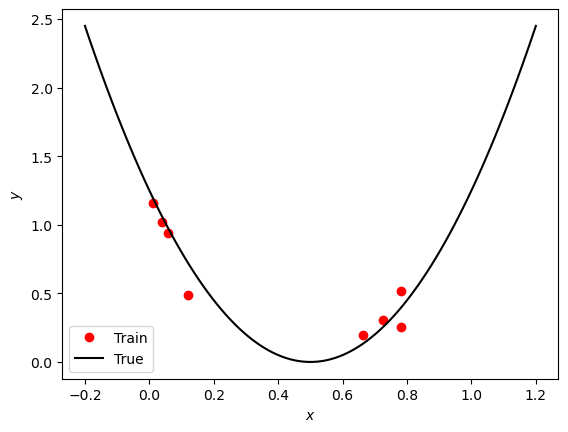

In [3]:
import numpy as np
import matplotlib.pyplot as plt
n = 8 # number of instances

# parameters
sigma = 0.1 # keep this small: don't want too much noise

# generate data matrix with rows as instances
X = np.random.uniform(size=(n,1))

# generate the target response values using the quadratic function and additive noise
Y = np.random.normal(loc=5*(X - 0.5)**2, scale=sigma, size=(n,1)).ravel()

# plot the training data
plt.plot(X, Y, 'ro', label='Train')

# and plot the true function (without noise)
X_test = np.linspace(-0.2, 1.2, 100)
X_test = X_test[:,np.newaxis]
Y_test_true = 5*(X_test - 0.5)**2
plt.plot(X_test, Y_test_true, 'k', label='True')
plt.legend()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

In [38]:
np.cov(Y)

array(0.14170925)

#### Polynomial basis functions
Since the relationship between $y$ and $x$ is non-linear, we'll apply polynomial basis expansion to degree $d$.
Specifically, we replace the original data matrix $\mathbf{X}$ by the transformed matrix $\mathbf{\Phi}$, as we have seen before in this workshop. Note that we have to include a column of ones to account for the bias term.

The function below is a wrapper around `sklearn.preprocessing.PolynomialFeatures`, which implements the above transformation on a train/test set.

In [9]:
from sklearn.preprocessing import PolynomialFeatures
def polynomial_features(X_train, X_test, degree, include_bias=True):
    """
    Augments data matrices X_train and X_test with polynomial features
    """
    poly = PolynomialFeatures(degree=degree, include_bias=include_bias)

    Phi_train = poly.fit_transform(X_train)
    Phi_test = poly.fit_transform(X_test)

    return Phi_train, Phi_test

Phi, Phi_test = polynomial_features(X, X_test, 9)
Phi_test

array([[ 1.00000000e+00, -2.00000000e-01,  4.00000000e-02,
        -8.00000000e-03,  1.60000000e-03, -3.20000000e-04,
         6.40000000e-05, -1.28000000e-05,  2.56000000e-06,
        -5.12000000e-07],
       [ 1.00000000e+00, -1.85858586e-01,  3.45434139e-02,
        -6.42019007e-03,  1.19324745e-03, -2.21775283e-04,
         4.12188405e-05, -7.66087540e-06,  1.42383947e-06,
        -2.64632790e-07],
       [ 1.00000000e+00, -1.71717172e-01,  2.94867871e-02,
        -5.06338768e-03,  8.69470611e-04, -1.49303034e-04,
         2.56378948e-05, -4.40246678e-06,  7.55979144e-07,
        -1.29814600e-07],
       [ 1.00000000e+00, -1.57575758e-01,  2.48301194e-02,
        -3.91262487e-03,  6.16534828e-04, -9.71509426e-05,
         1.53086334e-05, -2.41226950e-06,  3.80115194e-07,
        -5.98969397e-08],
       [ 1.00000000e+00, -1.43434343e-01,  2.05734109e-02,
        -2.95093368e-03,  4.23265235e-04, -6.07107711e-05,
         8.70800959e-06, -1.24902764e-06,  1.79153459e-07,
        -2.

### Bayesian Regression with Known Variance
Let's begin with a quick recap on Bayesian Linear Regression. The model assumes the data is generated according to a Normal distribution, where the mean is a linear function of the input vector and the variance $\sigma^2$ is **assumed known**.
The prior over the weight vector $\ws$ is also Normal—by setting the mean to zero and choosing a small $\gamma^2$, weights with large magnitude are penalised.
$$
\begin{align*}
\ws | \gamma &\sim \mathrm{Normal}\!\left[\mathbf{0}, \gamma^2 \mathbf{I}_m\right] & \mbox{Prior} \\
y | \mathbf{x}, \mathbf{w}, \sigma &\sim \mathrm{Normal}\!\left[\xs^\intercal \ws, \sigma^2\right] & \mbox{Likelihood}
\end{align*}
$$


Given this formulation, the next step is to solve for the posterior over $\ws$
$$
\begin{align*}
p(\ws | \Xs, \ys, \sigma, \gamma) = \frac{p(\ys | \Xs, \ws, \sigma) p(\ws | \gamma)}{p(\ys | \Xs, \sigma)}
\end{align*}
$$
where $\Xs \in \mathbb{R}^{n \times m}$ is the feature matrix and $\ys \in \mathbb{R}^{n}$ is the vector of target values for each instance.

In lectures, we derived the following solution:
$$
\ws | \Xs, \ys, \sigma, \gamma \sim  \textrm{Normal}(\ws_N, \mathbf{V}_N)
$$
where $\Vs_N = \sigma^2 \left( \Xs^\intercal \Xs + \frac{\sigma^2}{\gamma^2} \Is_m \right)^{-1}$ and $\ws_N = \frac{1}{\sigma^2} \Vs_N \Xs^\intercal \ys$.

#### Computing the posterior parameters
Complete the function below to compute the posterior mean $\mathbf{w}_N$ and covariance matrix $\mathbf{V}_N$ for the weights based on the expression above.

In [28]:
def compute_posterior_params(X, Y, sigma, gamma):
    """
    Compute the parameters (mean and covariance) for the posterior over the weights

    Arguments
    =========
    X : numpy array, shape: (n_instances, n_features)
        feature matrix
    Y : numpy array, shape: (n_instances,)
        target class labels relative to X
    sigma : float
        positive scale parameter for y
    gamma : float
        positive scale parameter for w_i

    Returns
    =======
    The following items in a tuple:
    w_N : numpy array, shape: (n_features,)
        mean parameter
    V_N : numpy array, shape: (n_features, n_features)
        covariance parameter
    """
    V_N = sigma**2 * np.linalg.inv(X.T @ X + (sigma/gamma)**2 * np.identity(X.shape[1])) # fill in
    w_N = np.ravel(1/sigma**2 * V_N @ X.T @ Y) # fill in

    return w_N, V_N

gamma = 10 # larger implies more permissive, i.e. a more diffuse prior
w_N, V_N = compute_posterior_params(Phi, Y, sigma, gamma)


In [29]:
w_N

array([ 1.2529745 , -6.63292046,  5.77335863,  3.65000153,  0.67855897,
       -0.92623357, -1.52272279, -1.57240546, -1.37006653, -1.08051234])

In [30]:
V_N

array([[ 8.11668910e-03, -1.15849598e-01,  2.07835004e-01,
        -2.53857485e-02, -4.85930175e-02, -3.55436605e-02,
        -1.95722097e-02, -6.29048891e-03,  3.49316454e-03,
         1.00604898e-02],
       [-1.15849598e-01,  2.56008859e+00, -6.40467173e+00,
         2.85126226e+00,  2.01031310e+00,  7.35660305e-01,
        -8.00506342e-02, -5.21773697e-01, -7.24507441e-01,
        -7.84410896e-01],
       [ 2.07835004e-01, -6.40467173e+00,  3.45740605e+01,
        -3.54525506e+01, -1.18825788e+01,  7.66015695e-01,
         6.43477477e+00,  8.23488097e+00,  8.07108201e+00,
         7.03417818e+00],
       [-2.53857485e-02,  2.85126226e+00, -3.54525506e+01,
         6.90840271e+01, -2.12451051e+01, -1.30508570e+01,
        -6.94907635e+00, -2.66055058e+00,  2.00581387e-01,
         1.99012003e+00],
       [-4.85930175e-02,  2.01031310e+00, -1.18825788e+01,
        -2.12451051e+01,  7.74590978e+01, -1.98443595e+01,
        -1.57290239e+01, -1.15230287e+01, -7.82896631e+00,
        -4.

Let's plot the prior and posterior over $\mathbf{w}$ to see how they differ.
Since $\mathbf{w}$ is $d+1$-dimensional, we can only visualise the posterior over a couple of the weights.
Here we look at $p(w_1, w_2|\mathbf{X}, \mathbf{y}, \sigma, \gamma)$.

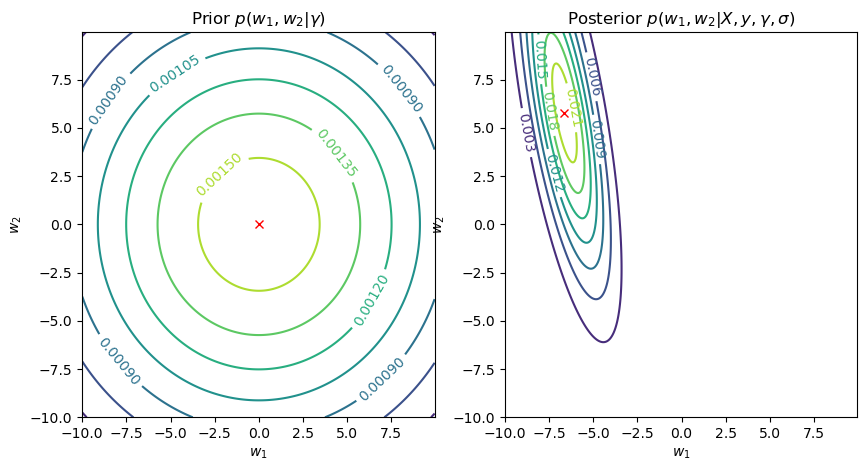

In [20]:
# set up a 2d plot mesh
import scipy as sp
from scipy.stats import multivariate_normal
w1, w2 = np.mgrid[-10:10:.05, -10:10:.05]
grid = np.c_[w1.ravel(), w2.ravel()]

fig = plt.figure(figsize=(10,5))
# plot a bivariate normal for the prior
ax = fig.add_subplot(121)
p_w = sp.stats.multivariate_normal.pdf(grid, mean=np.zeros(2), cov=gamma**2 * np.identity(2))
CS = ax.contour(w1, w2, p_w.reshape(w1.shape))
plt.clabel(CS, inline=1, fontsize=10)
ax.plot(0, 0, 'rx') # add prior mean
plt.xlabel('$w_1$')
plt.ylabel('$w_2$')
plt.title('Prior $p(w_1, w_2|\gamma)$')

# plot a bivariate normal for the posterior
ax = fig.add_subplot(122)
p_w = sp.stats.multivariate_normal.pdf(grid, mean=w_N[1:3], cov=V_N[1:3,1:3])
CS = ax.contour(w1, w2, p_w.reshape(w1.shape))
plt.clabel(CS, inline=1, fontsize=10)
ax.plot(w_N[1], w_N[2], 'rx') # add posterior mean
plt.xlabel('$w_1$')
plt.ylabel('$w_2$')
plt.title('Posterior $p(w_1, w_2|X,y,\gamma,\sigma)$')
plt.show()

**Discussion question**: Can you explain why the prior and the posterior are so different? How is this related to the dataset?  *You might want to change the parameter indices from 0,1 to other pairs to get a better idea of the full posterior.*

#### Bayesian Prediction (Inference)
One way of doing inference for $y|\mathbf{x}$ is to draw a sample of weight vectors from the posterior (sampling from a Gaussian).

Complete the function below to compute the predictive mean $E[y|\mathbf{x}] = \mathbf{w} \cdot \mathbf{x}$.
Then run the code block below to plot 50 samples from the posterior.

In [39]:
def target_mean(X, w):
    """
    Compute the predictive mean for the target variable, given X and w

    Arguments
    =========
    X : numpy array, shape: (n_instances, n_features)
        feature matrix
    w : numpy array, shape: (n_features,)
        weights vector

    Returns
    =======
    Y_mean : numpy array, shape: (n_instances,)
        predictive mean for each instance in X
    """
    # your code here #
    return np.dot(X, w)

In [41]:
w_i = np.random.multivariate_normal(w_N, V_N, 1).ravel()
w_i

array([  1.37853022,  -7.30148383,   8.50866258,   2.05409203,
         3.99096032, -11.64717901,   2.56820716,  -9.87179184,
         4.60183113,   8.68319202])

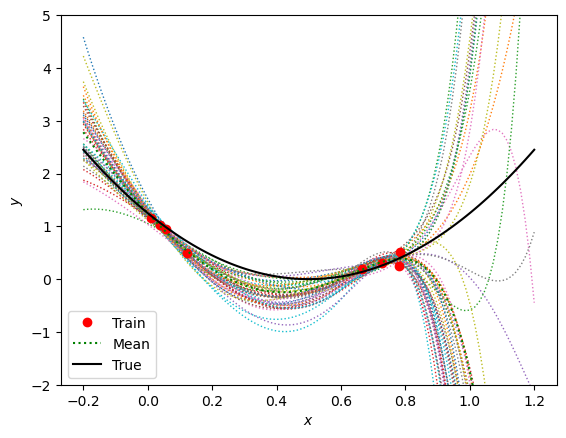

In [22]:
# generate some samples from the posterior
for i in range(50):
    # draw a weight vector
    w_i = np.random.multivariate_normal(w_N, V_N, 1).ravel()
    # plot the predictions for this weight vector
    p = plt.plot(X_test.ravel(), target_mean(Phi_test, w_i), ':', lw=1)

plt.plot(X, Y, 'ro', label='Train')
plt.plot(X_test, target_mean(Phi_test, w_N), 'g:', label='Mean')
plt.plot(X_test.ravel(), Y_test_true, 'k', label='True')

plt.ylim(-2,5)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()
plt.show()

***Discussion***: What do you observe from this plot?

***Answer*** It's interesting to see what happens near the training data points, and away from them, in particular the edges of the plot.
We'll come back to this.


There's a more elegant solution, as the predictive distribution can be found in closed form. Namely
$$
\begin{align*}
y_{*} | \xs_{*}, \ws_N, \Vs_N, \sigma &= \mathrm{Normal}\!\left[\xs_{*}'\ws_N, \sigma^2_N(\xs_{*})\right] \\
\sigma^2_N(\xs_{*}) & = \sigma^2 + \xs_{*}' \Vs_N \xs_{*}
\end{align*}
$$
Note that the predictive mean is a simple application of the posterior mean to the data point, but the predictive variance is a bit more complicated.

A function below is written to evaluate the predictive standard deviation, i.e. $\sigma_N(\mathbf{x}_{*})$.
Run the following code block to plot the results.

In [23]:
def target_std(X, V_N, sigma):
    """
    Compute the predictive standard deviation for the target variable, given X, V_N and sigma

    Arguments
    =========
    X : numpy array, shape: (n_instances, n_features)
        feature matrix
    V_N : numpy array, shape: (n_features, n_features)
        covariance parameter

    Returns
    =======
    std : numpy array, shape: (n_instances,)
        predictive standard deviation for each instance in X
    """
    # your code here #
    return np.sqrt(sigma**2 + np.sum(X * (X @ V_N), axis=1))

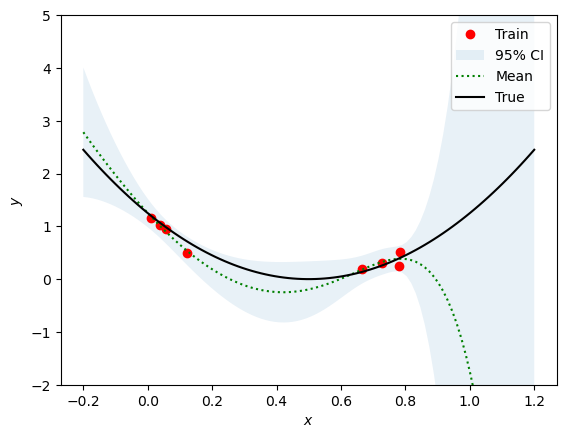

In [24]:
# compute the standard deviation using the formula above
Y_test_mean = target_mean(Phi_test, w_N)
Y_test_std = target_std(Phi_test, V_N, sigma)

plt.plot(X, Y, 'ro', label='Train')
plt.fill_between(X_test.ravel(), Y_test_mean + 2*Y_test_std, Y_test_mean - 2*Y_test_std, alpha=0.1, label='95% CI')
plt.plot(X_test.ravel(), Y_test_mean, 'g:', label='Mean')
plt.plot(X_test.ravel(), Y_test_true, 'k', label='True')

plt.ylim(-2,5)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()
plt.show()

**Discussion**: How does the uncertainty plot compare to the samples above? How does the uncertainty change relative to the distance from training points? Can you explain why?

**Practical**: How does the setting of `gamma` affect the fit? How about the number of instances in the training set? Try some other values and see what happens.

**Discussion**: Is a 9th order polynomial a good choice for this problem? Based on the results above, would you recommend this model, or make a different choice?

You can now try `Bayesian Ridge` from `sklearn.linear_model` for future problems to apply Bayesian Ridge

`from sklearn.linear_model import BayesianRidge`

### References
1. Pattern Recognition and Machine Learning, Christopher Bishop, New York, Springer,  2006. (Chapter 3)
2. Machine learning: A Probabilistic Perspective, Kevin Murphy, MIT Press, 2012. (Chapters 17, 18)
3. Statistical Machine Learning Course Workshop, 2015, University of Melbourne, Australia